In [1]:
%run srcnn.py
%matplotlib inline

/home/montero/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [13]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

from keras.callbacks import ModelCheckpoint
print(device_lib.list_local_devices())
print(K.tensorflow_backend._get_available_gpus())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1842137725902175271
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9936568320
locality {
  bus_id: 1
}
incarnation: 2154414692295409615
physical_device_desc: "device: 0, name: GeForce GTX TITAN X, pci bus id: 0000:04:00.0, compute capability: 5.2"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 10446471168
locality {
  bus_id: 2
}
incarnation: 1669289519154771923
physical_device_desc: "device: 1, name: GeForce GTX TITAN X, pci bus id: 0000:83:00.0, compute capability: 5.2"
]
['/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1']


### Load images

In [3]:
PATH = "datasets"
TRAIN_FILE = PATH + "/DIV2K_train_HR/"

In [4]:
obj_files = listdir(TRAIN_FILE )
imgs = []

for i in range(0,90):
    n = obj_files[i]
    img = Image.open(TRAIN_FILE + n)
    img = to_ycbcr(img)
    imgs.append(np.asarray(img))

(2040, 1356)


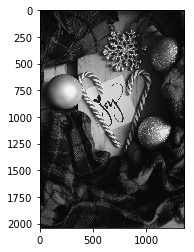

In [5]:
print(imgs[0].shape)

plt.imshow(imgs[0], 'gray')

### Generate train and test set
In the training phase, the ground truth images {Xi } are prepared as 32 × 32-
sub-images. To synthesize the low-resolution samples {Yi}, we blur a sub-image by a proper Gaussian kernel, sub-sample it by the upscaling factor, and upscale it by the same factor via bicubic interpolation. 
The sub-images are extracted from original images with a stride of 14.

#### Original image and bicubic interpolated image

1
1


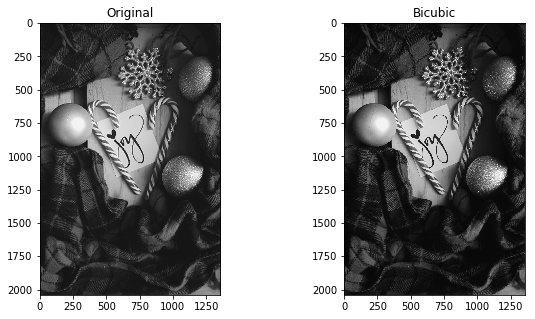

In [6]:
sample, label = get_input_images(imgs[0],  scale = 4. )
plot_images([sample, label], ["Bicubic", "Original"], ch=1)

1
1


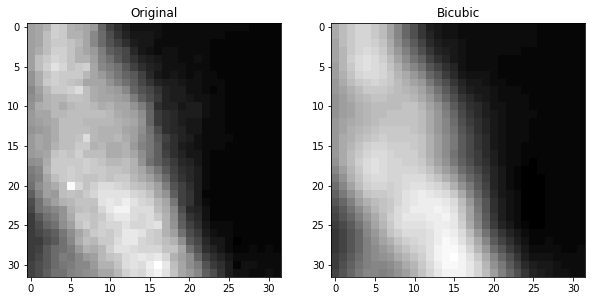

In [21]:
smp, ptch = generate_patches(imgs[0])

img_size = utility.getSize(smp[0])[0]
plot_images([smp[11], ptch[11]], ["Bicubic", "Original"], ch=1)

#### Example of our train and test set images

(32, 32)
1
1


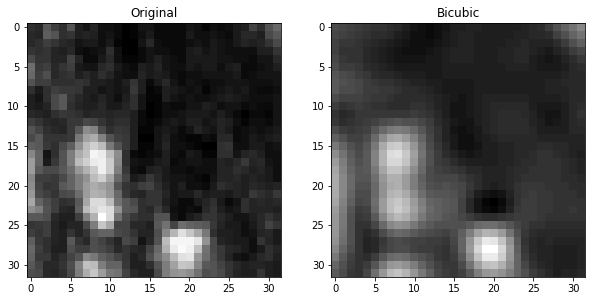

In [22]:
samples_list, labels_list = image_patches(imgs,  scale = 4.)

print(labels_list[500].shape)
plot_images([samples_list[500], labels_list[500]], ["Bicubic", "Original"], ch=1)

In [23]:
index = [i for i in range(len(samples_list))]
random.shuffle(index)

samples = np.asarray(samples_list)
labels = np.asarray(labels_list)

samples = samples
labels = labels


In [24]:
train, test = normalize(samples, labels)
train, test = reshape(train, test, ch=1)

### Convolutional Neural Networks

In [25]:
model = srcnn_mode()
srcnn_compile(model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 32, 32, 64)        640       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 32, 32, 64)        36928     
__________

In [27]:
batch_size = 64
epochs = 20

filepath="weights.best" +  "-{epoch:02d}-{val_loss:.2f}" + ".hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min', period=5)
callbacks_list = [checkpoint]

#model.load_weights("weights.best.hdf5")

model.fit(train, test,
          epochs=epochs,
          verbose=1,
          batch_size=batch_size,
          validation_split = 0.2,
          callbacks=callbacks_list)

Train on 996940 samples, validate on 249236 samples
Epoch 1/20
996940/996940 [==============================] - 1499s 2ms/step - loss: 0.0036 - psnr: 56.9790 - val_loss: 0.0044 - val_psnr: 65.7974
Epoch 2/20
996940/996940 [==============================] - 1535s 2ms/step - loss: 0.0035 - psnr: 57.2112 - val_loss: 0.0043 - val_psnr: 65.5988
Epoch 3/20
996940/996940 [==============================] - 1536s 2ms/step - loss: 0.0034 - psnr: 57.3142 - val_loss: 0.0043 - val_psnr: 65.2057
Epoch 4/20
996940/996940 [==============================] - 1405s 1ms/step - loss: 0.0034 - psnr: 57.3912 - val_loss: 0.0043 - val_psnr: 66.1094
Epoch 5/20
996940/996940 [==============================] - 887s 890us/step - loss: 0.0034 - psnr: 57.4476 - val_loss: 0.0043 - val_psnr: 64.6557

Epoch 00005: val_loss improved from inf to 0.00427, saving model to weights.best-05-0.00.hdf5
Epoch 6/20
996940/996940 [==============================] - 885s 888us/step - loss: 0.0033 - psnr: 57.4962 - val_loss: 0.0042 -

In [28]:
name = "sptial_deep_model_ycbcr"
save_model(model, name)

In [45]:
TEST_FILE5 = "datasets/SR_Test/Set5/"
def get_test_dataset(test_name = TEST_FILE5) :
    vald_pil = load_images([TEST_FILE5 ], channels=1)
    return vald_pil


(256, 256)
1
1


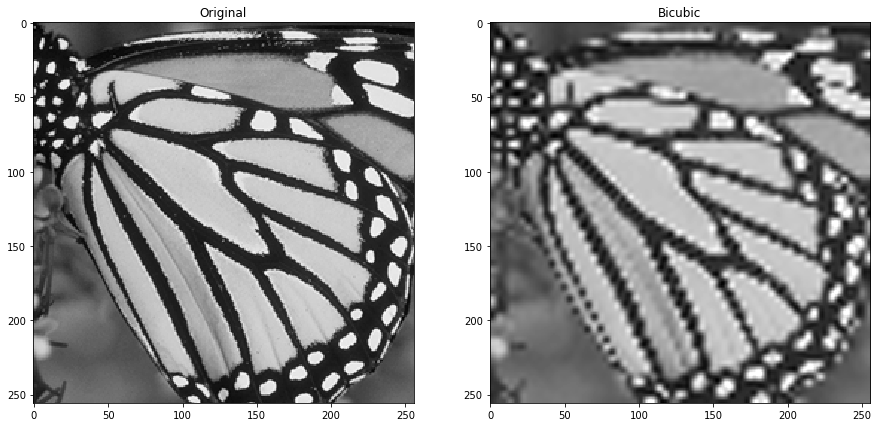

In [46]:
index=3
vald_pil = get_test_dataset()
val_img = vald_pil[index]

org, bicubic = get_input_images(val_img, 4.)

print(bicubic.shape)
plot_images([bicubic, org], ["Bicubic", "Original"], size=(15,10), ch=1)

In [47]:
val_img.shape

(256, 256)

In [48]:
#plt.imshow(im[0])

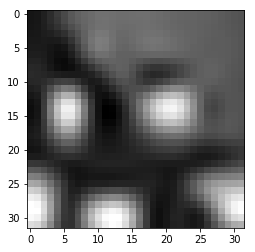

In [55]:
subBic, subOrg = generate_patches(val_img, 
                                  patch_size = 32, 
                                  label_size = 32, 
                                  scale = 4., 
                                  stride = 30 )
    
    
subBic = np.asarray(subBic)
subOrg = np.asarray(subOrg)


subOrg, subBic = normalize(subOrg, subBic)
subOrg, subBic = reshape(subOrg, subBic, ch=1)

plt.imshow(subBic[0][:,:, 0], 'gray')

In [56]:
pred = model.predict(subBic)
pred = pred.clip(0,1)
pred.shape

(64, 32, 32, 1)

In [57]:
h, w = utility.getSize(val_img)
image = patch_to_image(pred, h, w, 0, 32, 32, stride=30)

1
1
1


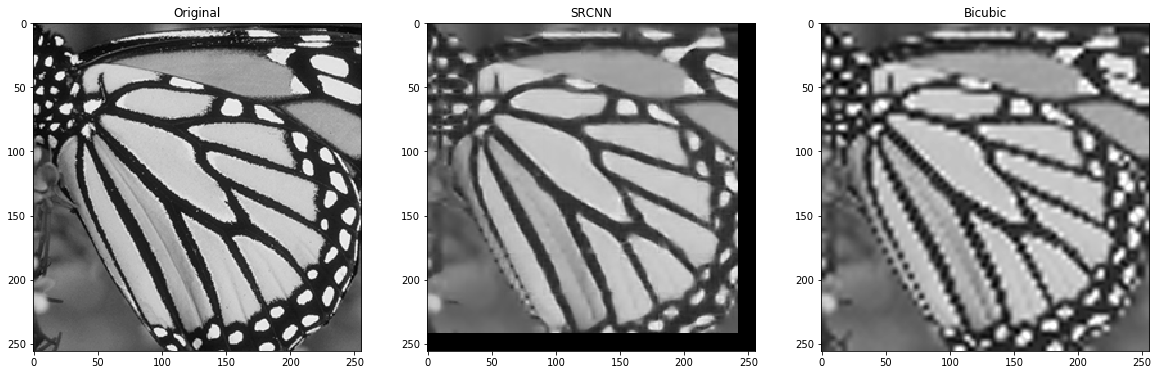

In [58]:
plot_images([bicubic, val_img, image], ["Bicubic", "Original", "SRCNN"], size=(20, 10))

### test.shape

1
1


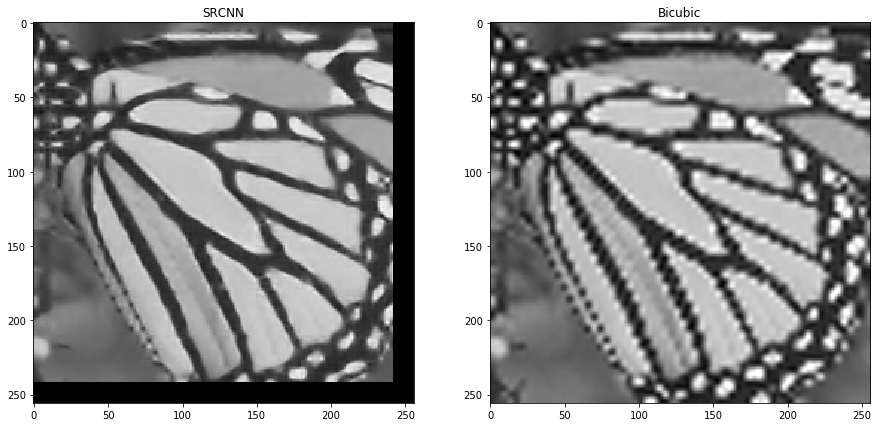

In [59]:
plot_images([bicubic, image], ["Bicubic", "SRCNN"], size=(15, 10))

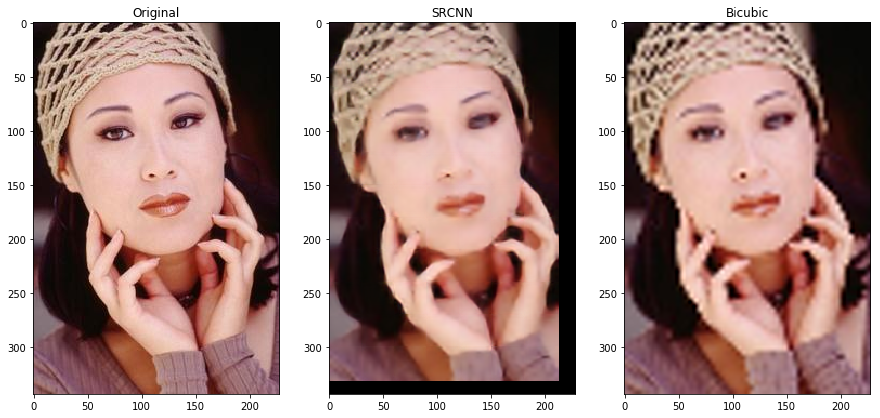

In [37]:
id = 0
val_img = vald_pil[id]

org, bic = get_input_images(val_img, 4.)
subBic, subOrg = generate_patches(val_img, 
                                  patch_size = 32, 
                                  label_size = 32, 
                                  scale = 4., 
                                  stride = 30 )
    
    
subBic = np.asarray(subBic)
subOrg = np.asarray(subOrg)

subOrg, subBic = normalize(subOrg, subBic)
subOrg, subBic = reshape(subOrg, subBic, ch=1)

pred = model.predict(subBic)
pred = pred.clip(0,1)

h, w = utility.getSize(val_img)
image = patch_to_image(pred, h, w, 0, 32, 32, stride=30)

plot_images([bic, org, image], ["Bicubic", "Original", "SRCNN"], size=(15, 15))

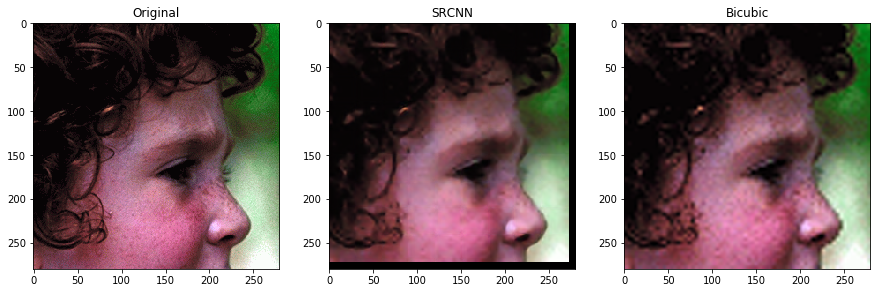

In [38]:
id = 2
val_img = vald_pil[id]

org, bic = get_input_images(val_img, 4)
subBic, subOrg = generate_patches(val_img, 
                                  patch_size = 32, 
                                  label_size = 32, 
                                  scale = 4, 
                                  stride = 30 )
    
    
subBic = np.asarray(subBic)
subOrg = np.asarray(subOrg)

subOrg, subBic = normalize(subOrg, subBic)
subOrg, subBic = reshape(subOrg, subBic, ch=1)

pred = model.predict(subBic, 64)
pred = pred.clip(0,1)

h, w = utility.getSize(val_img)
image = patch_to_image(pred, h, w, 0, 32, 32, stride=30)

plot_images([bic, org, image], ["Bicubic", "Original", "SRCNN"], size=(15, 15))

In [35]:
plot_images([bic, image], ["Bicubic", "SRCNN"], size=(15, 10))

# Load model

In [3]:
name = "sptial_deep_model_ycbcr"
#save_model(model, name)

In [ ]:
id = 3
l_model = load_model(name)

vald_pil = get_test_dataset()
img = vald_pil[id]

org, bic = get_input_images(img)
image = predict_image(l_model, img, stride=30)

plot_images([bic, org, image], ["Bicubic", "Original", "SRCNN"], size=(15, 15))